In [1]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import pairwise
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
import pandas as pd
from sklearn import preprocessing

In [2]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [3]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [600])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [600])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Lineal vs. Non-Lineal

In [4]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear'):
    data.kernel = kernel
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores)

In [5]:
#RANDOM_SELECTION()
#RANDOM_SELECTION(kernel='linear')

#data.kernel_matrix = 'poly'
#RANDOM_SELECTION(kernel='precomputed')

#data.kernel_matrix = None
#RANDOM_SELECTION(kernel='poly')

# SVM

In [6]:
@time_func
def SVM_RFE_W_STEP(step, C = 0.5, gamma = 3, kernel = 'linear', w1 = [0.8, 0.2]):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    kf = KFold(n_splits=6, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_kernel, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(kernel, C, gamma)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    

rbf 0.3 0.03


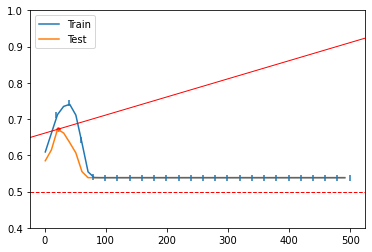

AT (21, 0.6716666666666667, 0.2710666666666666) WITH 25 ITERATIONS IN 126.76907293001811 SECONDS : 31.353932374286796
__main__.SVM_RFE_W_STEP - 00:02:13.786158700
rbf 0.3 0.032


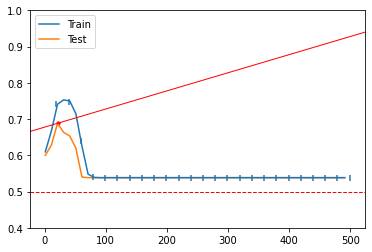

AT (21, 0.6883333333333334, 0.2577333333333333) WITH 25 ITERATIONS IN 128.3472739458084 SECONDS : 6.451258664383445
__main__.SVM_RFE_W_STEP - 00:02:13.420162100
rbf 0.3 0.034


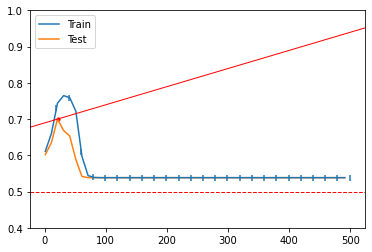

AT (21, 0.7000000000000001, 0.24839999999999995) WITH 25 ITERATIONS IN 121.36207056045532 SECONDS : 22.581022326964632
__main__.SVM_RFE_W_STEP - 00:02:07.738303100
rbf 0.3 0.036


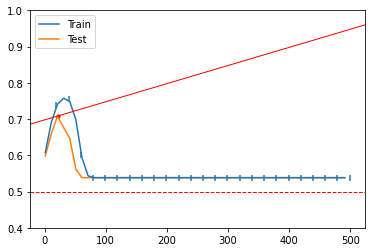

AT (21, 0.7083333333333334, 0.2417333333333333) WITH 25 ITERATIONS IN 122.01083600521088 SECONDS : 1.021318626606894
__main__.SVM_RFE_W_STEP - 00:02:05.803814700
rbf 0.3 0.038


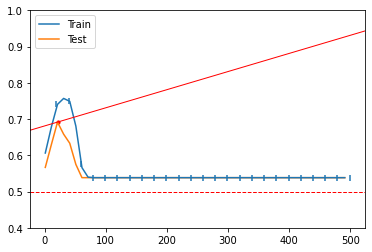

AT (21, 0.6916666666666668, 0.2550666666666666) WITH 25 ITERATIONS IN 121.50432244936626 SECONDS : 0.9568878891973264
__main__.SVM_RFE_W_STEP - 00:02:05.292950900
rbf 0.3 0.04


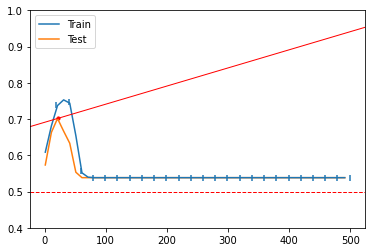

AT (21, 0.7016666666666667, 0.24706666666666668) WITH 25 ITERATIONS IN 122.9094484647115 SECONDS : 2.424223226224904
__main__.SVM_RFE_W_STEP - 00:02:07.316010300
rbf 0.3 0.042


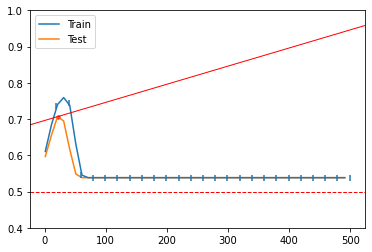

AT (21, 0.7066666666666667, 0.24306666666666668) WITH 25 ITERATIONS IN 122.64892800649007 SECONDS : 26.809658466847424
__main__.SVM_RFE_W_STEP - 00:02:09.317994200
rbf 0.3 0.044


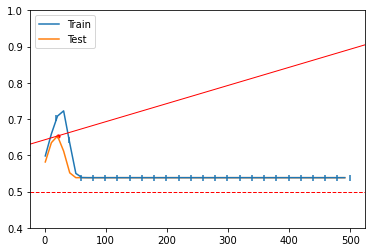

AT (21, 0.6533333333333334, 0.2857333333333333) WITH 25 ITERATIONS IN 123.95696087678273 SECONDS : 1.7155568644580592
__main__.SVM_RFE_W_STEP - 00:02:08.205420800
rbf 0.3 0.046


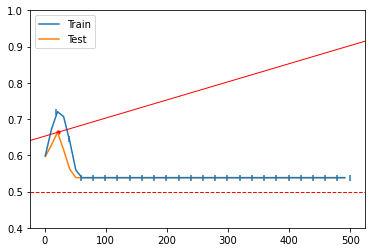

AT (21, 0.6633333333333334, 0.2777333333333333) WITH 25 ITERATIONS IN 123.43964644273122 SECONDS : 1.5781766458527955
__main__.SVM_RFE_W_STEP - 00:02:07.666495200


In [7]:
SVM_RFE_W_STEP(20, 0.3, 0.030, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.032, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.034, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.036, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.038, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.040, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.042, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.044, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.046, 'rbf')

rbf 0.4 0.032


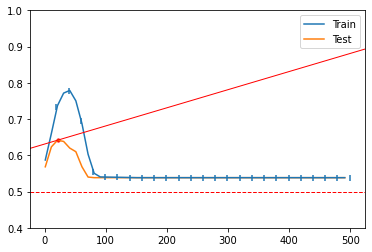

AT (21, 0.6416666666666667, 0.29506666666666664) WITH 25 ITERATIONS IN 127.36799395084381 SECONDS : 37.331404487348124
__main__.SVM_RFE_W_STEP - 00:02:14.656064800
rbf 0.4 0.034


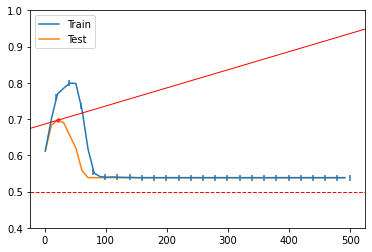

AT (21, 0.6966666666666668, 0.2510666666666666) WITH 25 ITERATIONS IN 126.2303163210551 SECONDS : 1.0987282769361602
__main__.SVM_RFE_W_STEP - 00:02:10.179344700
rbf 0.4 0.036


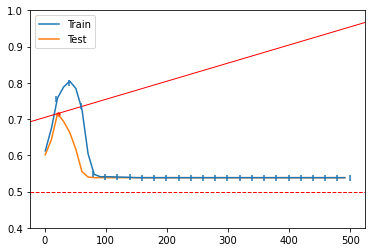

AT (21, 0.715, 0.23640000000000003) WITH 25 ITERATIONS IN 125.62991066773732 SECONDS : 1.4229965559321995
__main__.SVM_RFE_W_STEP - 00:02:09.857211100
rbf 0.4 0.038


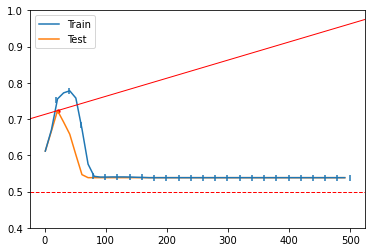

AT (21, 0.7233333333333333, 0.22973333333333337) WITH 25 ITERATIONS IN 132.35112178325653 SECONDS : 2.827696946205942
__main__.SVM_RFE_W_STEP - 00:02:16.672695300
rbf 0.4 0.04


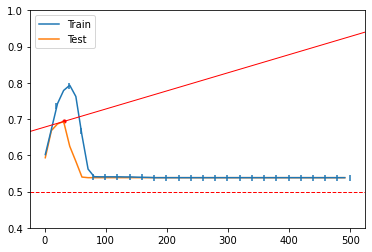

AT (31, 0.6933333333333334, 0.2577333333333333) WITH 25 ITERATIONS IN 122.37364439169566 SECONDS : 1.9055081256645854
__main__.SVM_RFE_W_STEP - 00:02:06.625126200
rbf 0.4 0.042


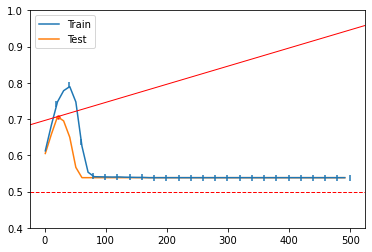

AT (21, 0.7066666666666667, 0.24306666666666668) WITH 25 ITERATIONS IN 123.95691907405853 SECONDS : 4.892651338621245
__main__.SVM_RFE_W_STEP - 00:02:08.637974500


In [8]:
SVM_RFE_W_STEP(20, 0.4, 0.032, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.034, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.036, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.038, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.040, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.042, 'rbf')

rbf 0.5 0.032


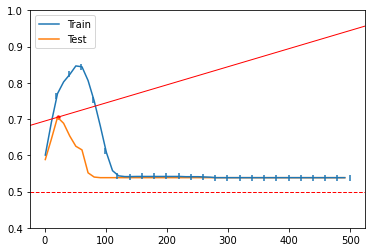

AT (21, 0.7050000000000001, 0.24439999999999995) WITH 25 ITERATIONS IN 122.55735913912456 SECONDS : 3.9563241443731205
__main__.SVM_RFE_W_STEP - 00:02:07.035820400
rbf 0.5 0.034


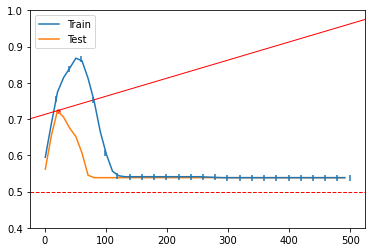

AT (21, 0.7233333333333333, 0.22973333333333337) WITH 25 ITERATIONS IN 123.03253857294719 SECONDS : 5.352426478078763
__main__.SVM_RFE_W_STEP - 00:02:07.768589100
rbf 0.5 0.036


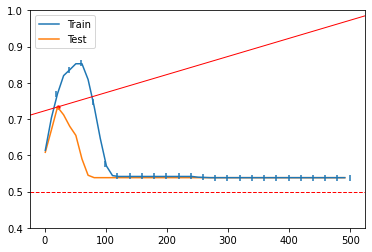

AT (21, 0.7333333333333334, 0.22173333333333328) WITH 25 ITERATIONS IN 122.8701862891515 SECONDS : 1.1686159541724506
__main__.SVM_RFE_W_STEP - 00:02:06.996556800
rbf 0.5 0.038


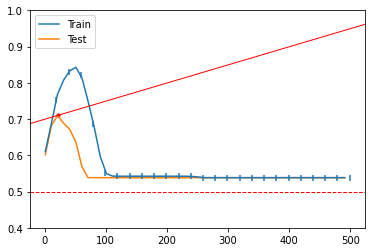

AT (21, 0.71, 0.24040000000000003) WITH 25 ITERATIONS IN 123.23382755120595 SECONDS : 1.3708603555396512
__main__.SVM_RFE_W_STEP - 00:02:07.307697600
rbf 0.5 0.04


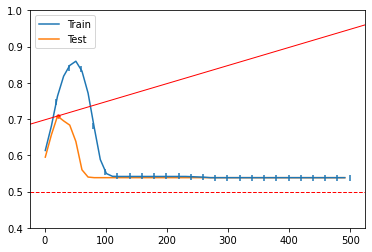

AT (21, 0.7083333333333334, 0.2417333333333333) WITH 25 ITERATIONS IN 123.21166296799977 SECONDS : 1.119523359809239
__main__.SVM_RFE_W_STEP - 00:02:07.109850000
rbf 0.5 0.042


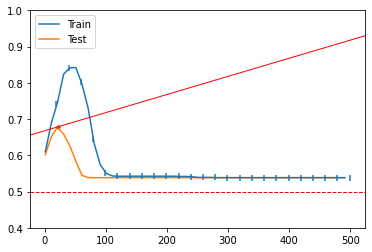

AT (21, 0.6783333333333333, 0.2657333333333334) WITH 25 ITERATIONS IN 123.9912379582723 SECONDS : 25.582598241366885
__main__.SVM_RFE_W_STEP - 00:02:10.646704500
rbf 0.5 0.044


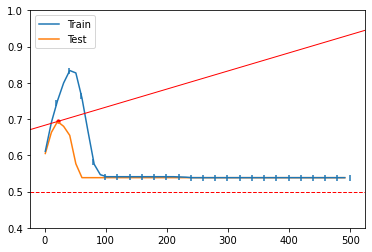

AT (21, 0.6933333333333334, 0.2537333333333333) WITH 25 ITERATIONS IN 122.3110316991806 SECONDS : 22.519854127626875
__main__.SVM_RFE_W_STEP - 00:02:08.715250000
rbf 0.5 0.046


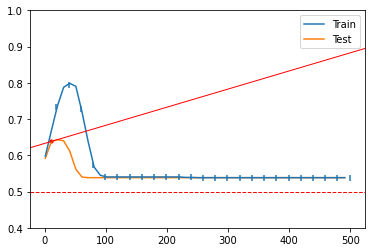

AT (11, 0.6383333333333333, 0.2937333333333334) WITH 25 ITERATIONS IN 127.48023593425751 SECONDS : 3.237937568327079
__main__.SVM_RFE_W_STEP - 00:02:12.197437200


In [9]:
SVM_RFE_W_STEP(20, 0.5, 0.032, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.034, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.036, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.038, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.040, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.042, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.044, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.046, 'rbf')

In [ ]:
SVM_RFE_W_STEP(20, 0.6, 0.026, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.028, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.030, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.032, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.034, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.036, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.038, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.040, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.042, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.044, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.046, 'rbf')